In [157]:
!pip install -q phik shap

In [158]:
!pip install -q catboost

In [159]:
from sqlalchemy import create_engine, text

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [160]:
import re

In [161]:
import phik
from phik import report
from phik.report import plot_correlation_matrix
import shap
shap.initjs() # JavaScript plots

In [162]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
pd.options.mode.chained_assignment = None
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer

In [163]:
from catboost import CatBoostClassifier, Pool
from hyperopt import fmin, hp, tpe
from lightgbm import LGBMClassifier as lgb

In [164]:
from sklearn.cluster import KMeans

In [165]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Dense, Dropout, BatchNormalization)

In [166]:
!pip install scikeras

In [167]:
import scikeras
from scikeras.wrappers import KerasClassifier

In [168]:
SEED = 171023

# Загрузка данных

Создание подключения

In [169]:
db_config = {
            'user': 'praktikum_student', # Имя пользователя
            'pwd': 'Sdf4$2;d-d30pp', # Пароль
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net', # Хост
            'port': 6432, # Порт подключения
            'db': 'data-science-final' # Название базы данных,
            }

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

engine = create_engine(connection_string)

In [170]:
engine = create_engine(connection_string)

Запрос к таблицам базы данных

In [171]:
tables_to_query = ['contract', 'personal', 'internet', 'phone']

dataframes = {} # Создаем пустой словарь для хранения данных

with engine.begin() as conn:

    for table in tables_to_query:

        query = text(f'SELECT * FROM telecom.{table}')

        dataframes[table] = pd.read_sql_query(query, conn)



df_contract = dataframes['contract']

df_personal = dataframes['personal']

df_internet = dataframes['internet']

df_phone = dataframes['phone']

# **Исследовательский анализ данных**

In [172]:
# напишем функцию для получения информации по датасетам и анализа
def show_info(name, data):
    print(name)
    print('\n')
    display(data.head())
    print('\n')
    data.info()
    print('\n')
    print(data.describe())
    print('\n')
    print('Количество дубликатов')
    print('\n')
    print(data[data.duplicated()].sum())
    print('\n')
    print('Количество пропусков')
    print('\n')
    print(data.isna().sum())
    print('\n')
    print('--------------------------------------------------------------------------------------------------------------------------------')

In [173]:
# создадим функцию для проверки количества уникальных категориальных значений и их значений

listing = ['customerID','BeginDate','EndDate','MonthlyCharges', 'TotalCharges'] # создадим список столбцов с некатегориальными данными
def check_unique(data):

    for column in data.columns:
        if column in listing:
            print()
        else:
            print(f'Количество уникальных значений столбца {column}: {data[column].nunique()}')
            print(data[column].unique())
            print('-----------------------------')

In [174]:
show_info('Информация о договорах', df_contract)

Информация о договорах




,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


       MonthlyCharges  TotalCharges
count     7043.000000   7032.000000
mean        64.761692   2283.300441
std         30.090047   2266.771362
min         18.250000     18.800000
25%         35.500000    401.450000
50%         70.350000   1397.475000
75%         89.850000   3794.737500
max        118.750000   8684.800000


Количество дубликатов


customerID      

In [175]:
check_unique(df_contract)




Количество уникальных значений столбца Type: 3
['Two year' 'Month-to-month' 'One year']
-----------------------------
Количество уникальных значений столбца PaperlessBilling: 2
['Yes' 'No']
-----------------------------
Количество уникальных значений столбца PaymentMethod: 4
['Bank transfer (automatic)' 'Mailed check' 'Electronic check'
 'Credit card (automatic)']
-----------------------------




In [176]:
show_info('Персональные данные клиентов', df_personal)

Персональные данные клиентов




,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


Количество дубликатов


customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64


Количество пропусков


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


-------------------------------------------------------------------

In [177]:
check_unique(df_personal)


Количество уникальных значений столбца gender: 2
['Female' 'Male']
-----------------------------
Количество уникальных значений столбца SeniorCitizen: 2
[0 1]
-----------------------------
Количество уникальных значений столбца Partner: 2
['Yes' 'No']
-----------------------------
Количество уникальных значений столбца Dependents: 2
['No' 'Yes']
-----------------------------


In [178]:
show_info('Информация об интернет-услугах', df_internet)

Информация об интернет-услугах




,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


                c1           c2    c3    c4    c5    c6    c7    c8
count         5518         5518  5518  5518  5518  5518  5518  5518
unique        5518            3     3     3     3     3     3     3
top     customerID  Fiber optic    No    No    No    No    No    No
freq             1         3096  3498  3088  3095  3473  2810  2785


Количество дубликатов


c1    0.0
c2    0.0
c3    0.0
c4    0.0
c5    0.0
c6    0.0
c7    0.0
c8    0.0
dtype: float64


Количество пропусков


c1

Исправим названия столбцов

In [179]:
internet_columns = df_internet.iloc[0]
df_internet = df_internet[1:]
df_internet.columns = internet_columns
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [180]:
check_unique(df_internet)


Количество уникальных значений столбца InternetService: 2
['DSL' 'Fiber optic']
-----------------------------
Количество уникальных значений столбца OnlineSecurity: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца OnlineBackup: 2
['Yes' 'No']
-----------------------------
Количество уникальных значений столбца DeviceProtection: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца TechSupport: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца StreamingTV: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца StreamingMovies: 2
['No' 'Yes']
-----------------------------


In [181]:
show_info('Иинформация об услугах телефонии', df_phone)

Иинформация об услугах телефонии




,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


                c1    c2
count         6362  6362
unique        6362     3
top     customerID    No
freq             1  3390


Количество дубликатов


c1    0.0
c2    0.0
dtype: float64


Количество пропусков


c1    0
c2    0
dtype: int64


--------------------------------------------------------------------------------------------------------------------------------


In [182]:
phone_columns = df_phone.iloc[0]
df_phone = df_phone[1:]
df_phone.columns = phone_columns
df_phone.head()

,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


In [183]:
 check_unique(df_phone)


Количество уникальных значений столбца MultipleLines: 2
['No' 'Yes']
-----------------------------


Создано подключение к базе данных, и загружены данные из 4х таблиц:

- contract — информация о договорах;
- personal — персональные данные клиентов;
- internet — информация об интернет-услугах;
- phone — информация об услугах телефонии.

Все таблицы содержат данные, количество таблиц соответствует условию задачи.



# **Предобработка данных**

Объединим таблицы по ключу customerID

In [184]:
df = df_personal.merge(df_contract, on ='customerID', how='outer')
df = df.merge(df_internet, on ='customerID', how = 'outer')
df = df.merge(df_phone, on ='customerID', how = 'outer')
show_info('Объединенная таблица', df)

Объединенная таблица




,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2019-04-29,None,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2019-03-26,None,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2018-12-22,None,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No




<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           1869 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7032 non-null   float64
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object

In [185]:
# заменим значения в столбце SeniorCitizen на категориальные 'Yes' и 'No'
df['SeniorCitizen'] = df['SeniorCitizen'].replace(0, 'No')
df['SeniorCitizen'] = df['SeniorCitizen'].replace(1, 'Yes')
df['SeniorCitizen'].unique()

array(['No', 'Yes'], dtype=object)

In [186]:
# заполним пропуски новыми категориями No internet или No phone в зависимости от столбца
df['InternetService'] = df['InternetService'].fillna('No internet')
df['OnlineSecurity'] = df['OnlineSecurity'].fillna('No internet')
df['OnlineBackup'] = df['OnlineBackup'].fillna('No internet')
df['DeviceProtection'] = df['DeviceProtection'].fillna('No internet')
df['TechSupport'] = df['TechSupport'].fillna('No internet')
df['StreamingTV'] = df['StreamingTV'].fillna('No internet')
df['StreamingMovies'] = df['StreamingMovies'].fillna('No internet')
df['MultipleLines'] = df['MultipleLines'].fillna('No phone')

In [187]:
# выделим в целевую переменную признак EndDate
df['Termination'] = df['EndDate']
df['Termination'] = df['Termination'].fillna(0)
df.loc[df['Termination'] != 0, 'Termination'] = 1
df['Termination'] = df['Termination'].astype('Int64')
df['Termination'].unique()

<IntegerArray>
[0, 1]
Length: 2, dtype: Int64

In [188]:
# сгенерируем новый признак SubscriptionDuration - длительность контракта абонента
# изменим тип данных на datetime, а пропуски в столбце EndDate заполним датой, на который актуальна информация о договорах

df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['EndDate'] = df['EndDate'].fillna(pd.to_datetime('01-02-2020', format='%d-%m-%Y'))
df['SubscriptionDuration'] = (df['EndDate'] - df['BeginDate']).dt.days

df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Termination,SubscriptionDuration
0,7590-VHVEG,Female,No,Yes,No,2019-04-29,2020-02-01,Month-to-month,Yes,Electronic check,...,DSL,No,Yes,No,No,No,No,No phone,0,278
1,5575-GNVDE,Male,No,No,No,2019-03-26,2020-02-01,One year,No,Mailed check,...,DSL,Yes,No,Yes,No,No,No,No,0,312
2,3668-QPYBK,Male,No,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,...,DSL,Yes,Yes,No,No,No,No,No,1,479


In [189]:
# во избежание утечки данных
# удалим столбцы, использованные для создания нового признака

df = df.drop(['BeginDate', 'EndDate'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customerID            7043 non-null   object 
 1   gender                7043 non-null   object 
 2   SeniorCitizen         7043 non-null   object 
 3   Partner               7043 non-null   object 
 4   Dependents            7043 non-null   object 
 5   Type                  7043 non-null   object 
 6   PaperlessBilling      7043 non-null   object 
 7   PaymentMethod         7043 non-null   object 
 8   MonthlyCharges        7043 non-null   float64
 9   TotalCharges          7032 non-null   float64
 10  InternetService       7043 non-null   object 
 11  OnlineSecurity        7043 non-null   object 
 12  OnlineBackup          7043 non-null   object 
 13  DeviceProtection      7043 non-null   object 
 14  TechSupport           7043 non-null   object 
 15  StreamingTV          

0    0.73463
1    0.26537
Name: Termination, dtype: Float64


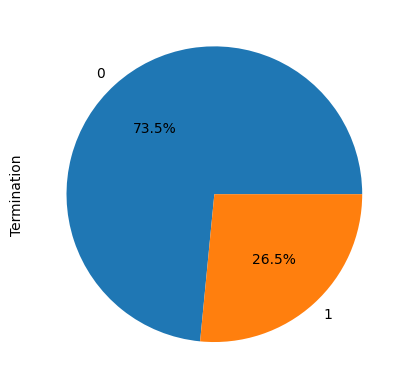

In [190]:
# проверим, как часто в целевом признаке встречается класс «1» или «0»
class_frequency = df['Termination'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='pie', y = "Termination",
                                       label = "Termination",
                                       autopct='%1.1f%%')
plt.show()

Соотношение классов примерно 3 к 1, следовательно классы сильно несбалансированы.

In [191]:
#!pip uninstall seaborn
#!pip install seaborn==0.11.0
#sns.__version__

In [192]:
#!pip install ptitprince

In [193]:
#import ptitprince as pt
#dx = "Termination"; dy = "MonthlyCharges"; ort = "h"; pal = "Set2"; sigma = .2
#f, ax = plt.subplots(figsize=(15, 10))

#ax=pt.RainCloud(x = dx, y = dy, data = df, palette = pal, bw = sigma,
 #                width_viol = .6, ax = ax, orient = ort, move = .2)

#plt.title("Rainclouds");

In [194]:
# удалим пропуски в столбце TotalCharges так как их всего 11
df = df.drop(df[df['TotalCharges'].isna()].index, axis=0)
df = df.reset_index(drop=True)
# удалим ненужный столбец
df = df.drop('customerID', axis = 1)

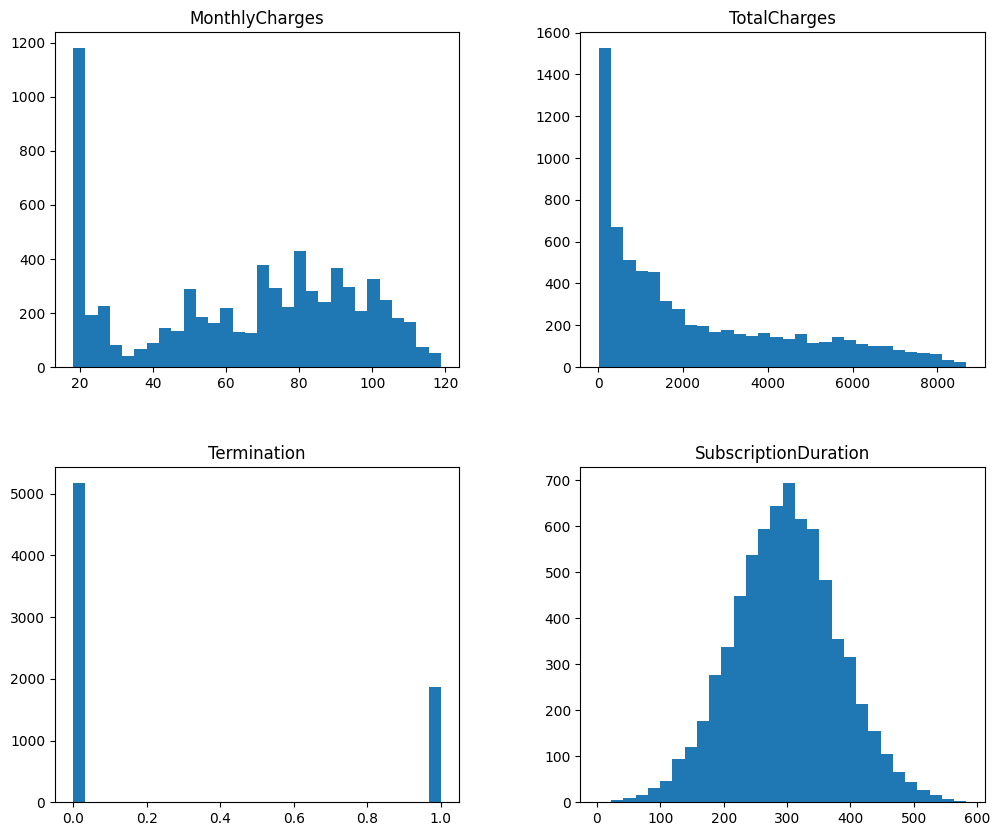

In [195]:
df.hist(bins = 30, figsize = (12,10), grid = False)
plt.show()

Проверим на выбросы численные столбцы с помощью визуализации и IQR (межквартильного диапазона)

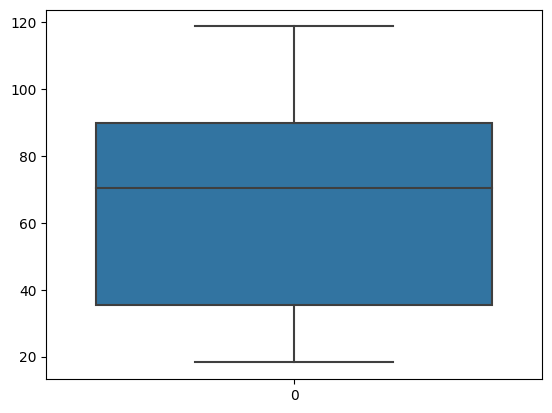

In [196]:
# построим ящик с усами
sns.boxplot(df['MonthlyCharges']);

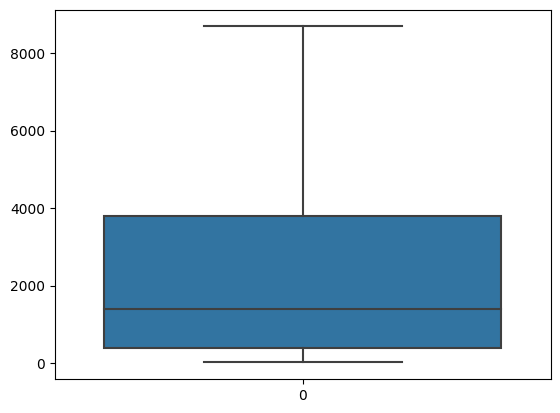

In [197]:
sns.boxplot(df['TotalCharges']);

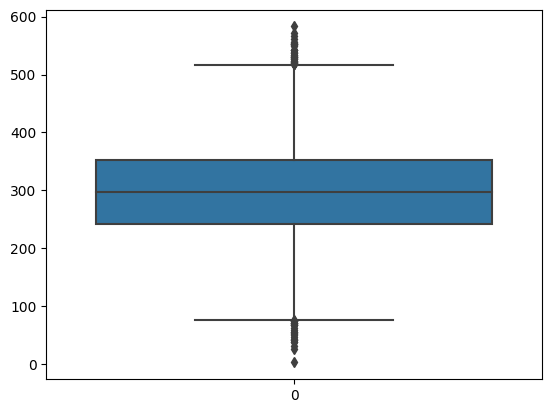

In [198]:
sns.boxplot(df['SubscriptionDuration']);

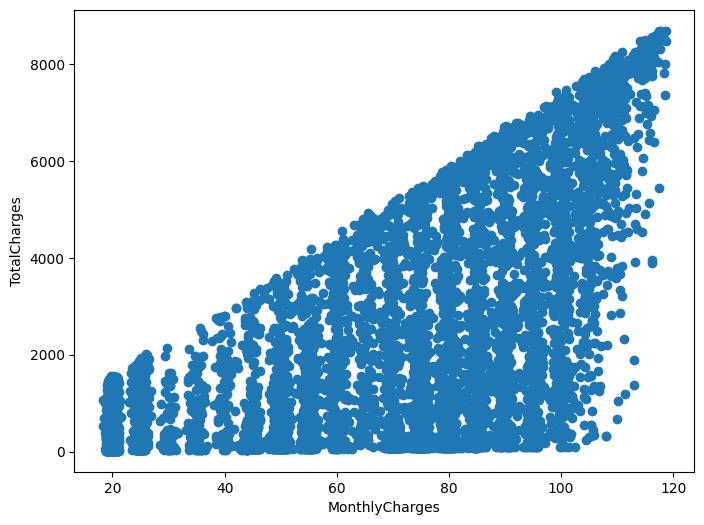

In [199]:
# построим диаграмму рассеяния
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(df['MonthlyCharges'],df['TotalCharges'])

# x-axis label
ax.set_xlabel('MonthlyCharges')

# y-axis label
ax.set_ylabel('TotalCharges')
plt.show()

Переменные имеют сильную линейную связь

In [200]:
# IQR
# расчитаем нижнию и верхнию границы
Q1 = df['MonthlyCharges'].quantile(0.25)
Q3 = df['MonthlyCharges'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# создадим массивы булевых значений, указывающих на строку с выбросам
upper_array = np.where(df['MonthlyCharges']>=upper)[0]
lower_array = np.where(df['MonthlyCharges']<=lower)[0]
# удалим выбросы
df['MonthlyCharges'].drop(index=upper_array, inplace=True)
df['MonthlyCharges'].drop(index=lower_array, inplace=True)

# проверим размер нового датафрейма
print("New Shape: ", df.shape)

New Shape:  (7032, 19)


In [201]:
# IQR

Q1 = df['TotalCharges'].quantile(0.25)
Q3 = df['TotalCharges'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

upper_array = np.where(df['TotalCharges']>=upper)[0]
lower_array = np.where(df['TotalCharges']<=lower)[0]

df['TotalCharges'].drop(index=upper_array, inplace=True)
df['TotalCharges'].drop(index=lower_array, inplace=True)

print("New Shape: ", df.shape)

New Shape:  (7032, 19)


In [202]:
# IQR

Q1 = df['SubscriptionDuration'].quantile(0.25)
Q3 = df['SubscriptionDuration'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

upper_array = np.where(df['SubscriptionDuration']>=upper)[0]
lower_array = np.where(df['SubscriptionDuration']<=lower)[0]

df['SubscriptionDuration'].drop(index=upper_array, inplace=True)
df['SubscriptionDuration'].drop(index=lower_array, inplace=True)

print("New Shape: ", df.shape)

New Shape:  (7032, 19)


Столбцы MonthlyCharges и TotalCharges не содержат выбросы.
Столбец SubscriptionDuration содержит выбросы, однако они укладываются в межквартильный диапазон.

In [203]:
# создадим функцию для визуализации данных по каждому признаку
def visualise(index, title):
    pivot = pd.DataFrame(df.pivot_table(index=index, aggfunc="size").sort_values(ascending=False)).head(15)
    pivot.columns = ['count']
    plt.figure(figsize=(6,3))
    plt.title(title)
    sns.barplot(x='count', y=pivot.index, data=pivot)

In [204]:
# создадим функцию для визуализации соотношения ушедших и оставшихся клиентов для каждого признака
# в каждом классе данные разделены на оставшихся (0) и ушедших (1)
def visualise_corr(index, title):

    plt.figure(figsize=(6,3))
    plt.title(title)

    sns.countplot(x = 'Termination', hue = index, data = df)

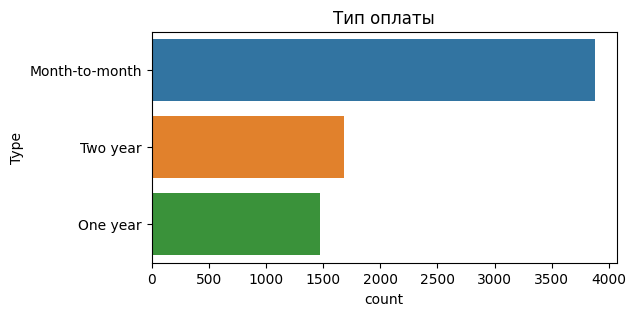

In [205]:
visualise('Type', 'Тип оплаты')

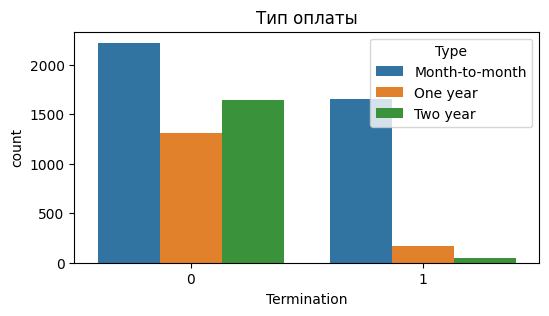

In [206]:
visualise_corr('Type', 'Тип оплаты')

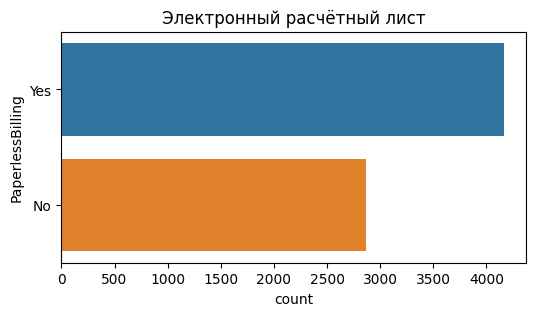

In [207]:
visualise('PaperlessBilling', 'Электронный расчётный лист')

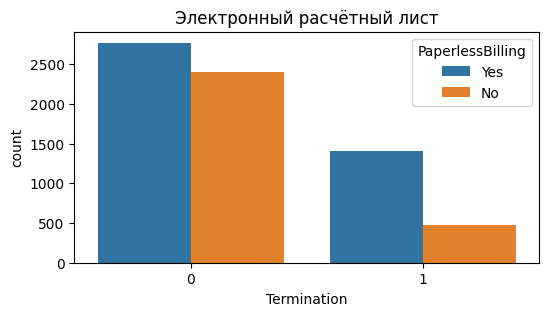

In [208]:
visualise_corr('PaperlessBilling', 'Электронный расчётный лист')

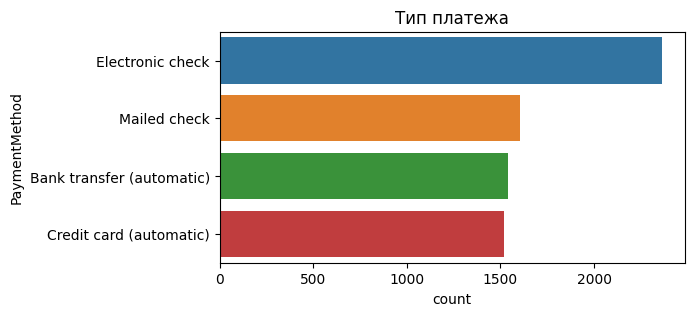

In [209]:
visualise('PaymentMethod', 'Тип платежа')

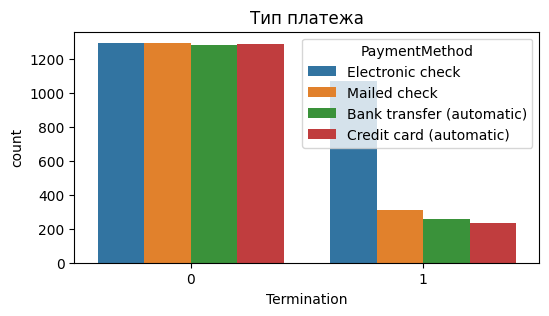

In [210]:
visualise_corr('PaymentMethod', 'Тип платежа')

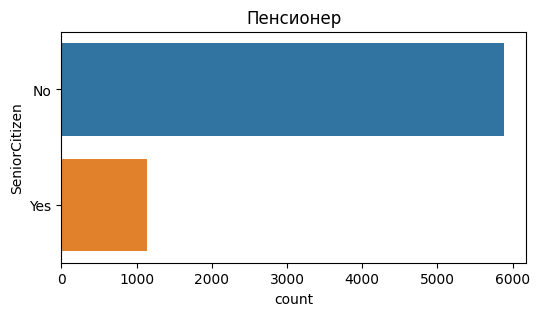

In [211]:
visualise('SeniorCitizen', 'Пенсионер')

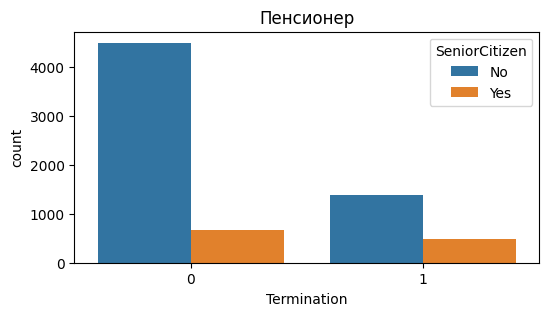

In [212]:
visualise_corr('SeniorCitizen', 'Пенсионер')

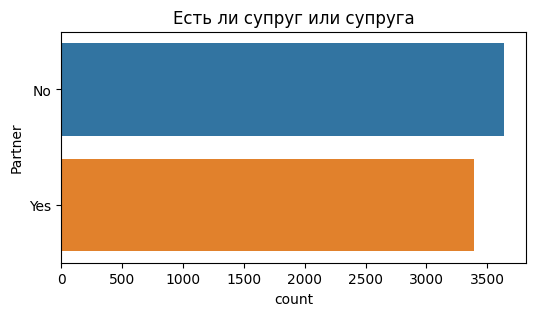

In [213]:
visualise('Partner', 'Есть ли супруг или супруга')

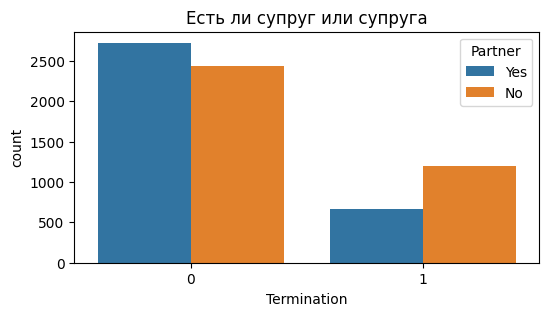

In [214]:
visualise_corr('Partner', 'Есть ли супруг или супруга')

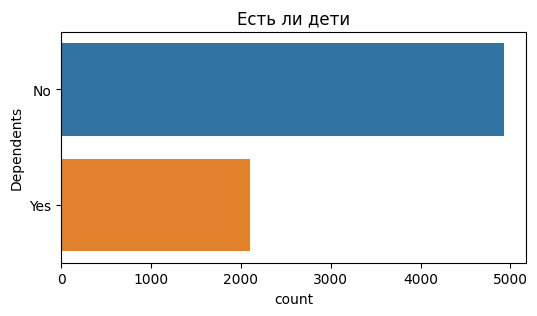

In [215]:
visualise('Dependents', 'Есть ли дети')

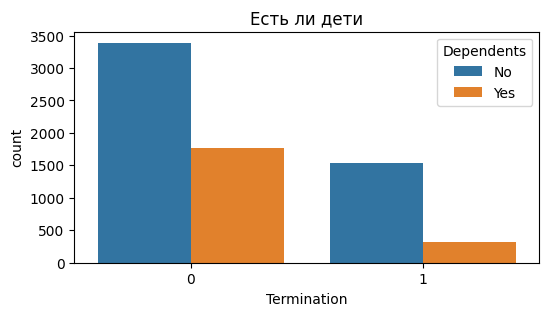

In [216]:
visualise_corr('Dependents', 'Есть ли дети')

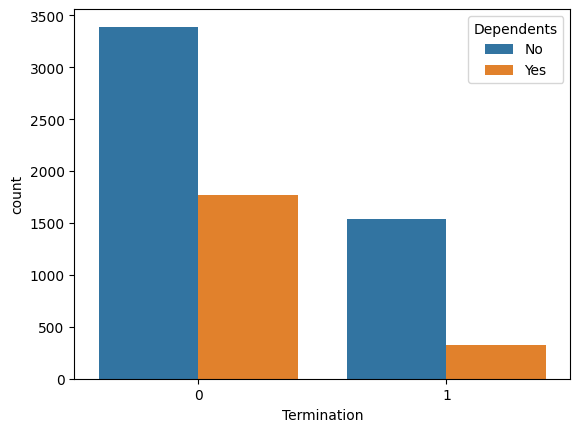

In [217]:
# создадим grouped countplot, где по оси x будет класс, а по оси y - количество пассажиров
# в каждом классе данные разделены на погибших (0) и выживших (1)
sns.countplot(x = 'Termination', hue = 'Dependents', data = df);

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Termination', 'SubscriptionDuration']


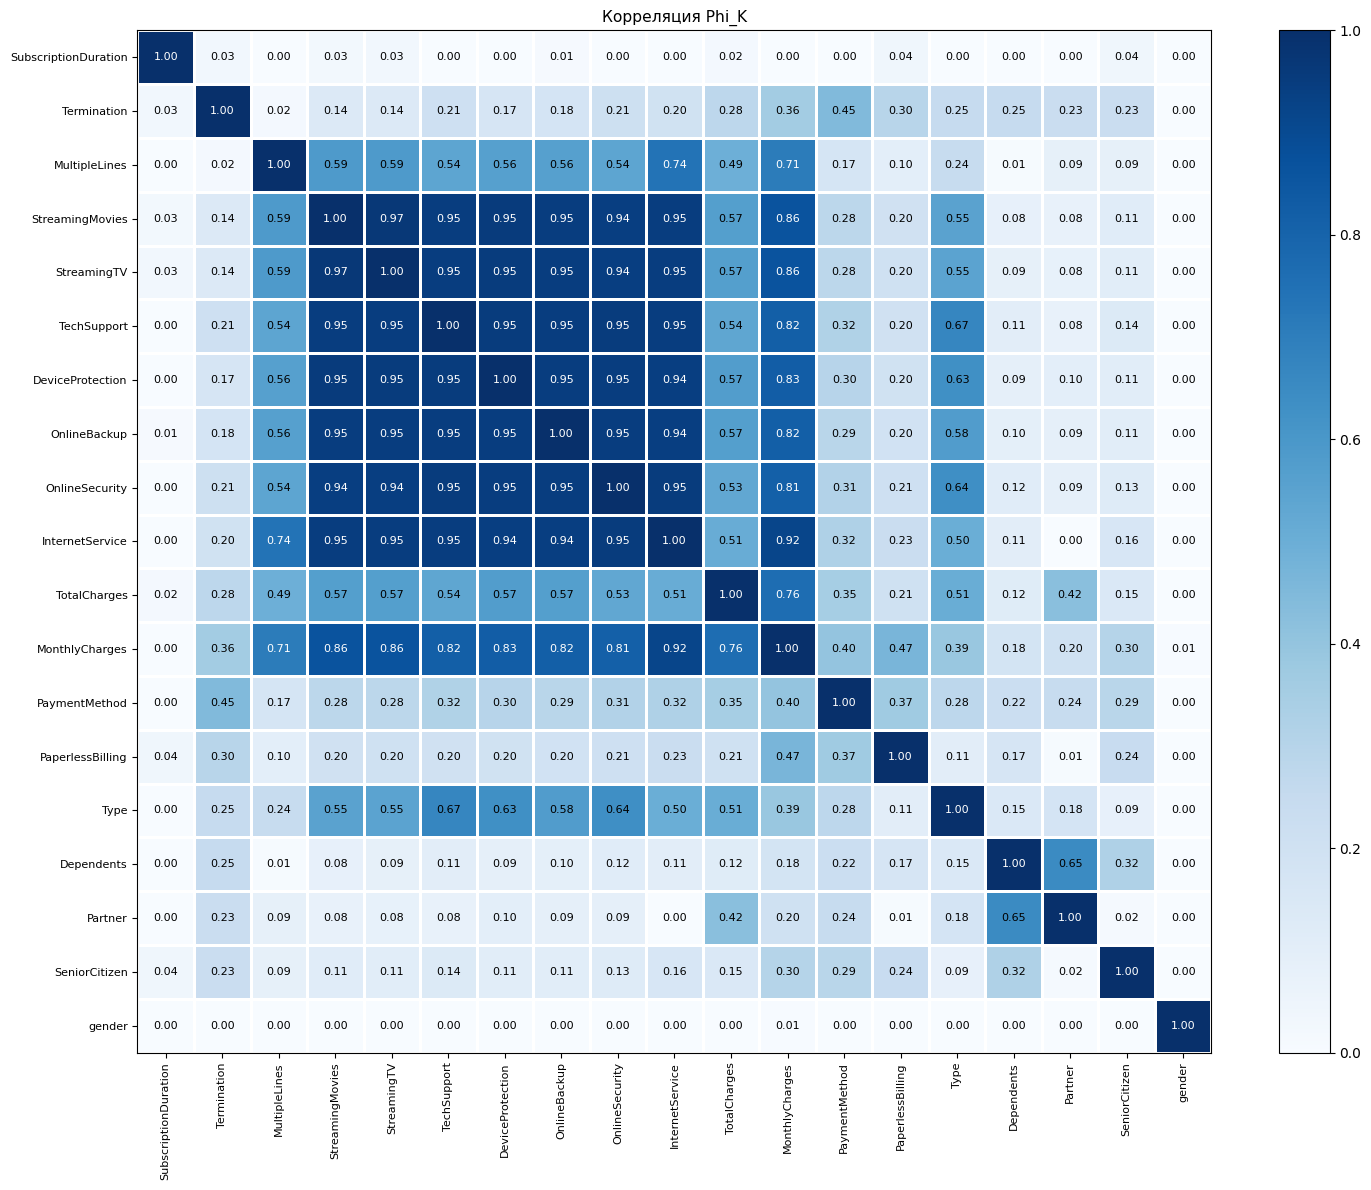

In [218]:
# выведем корреляюцию с помощью Phi_K, позволяющая вывести корреляцию между численными и категориальными данными
phik_overview = df.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"Корреляция Phi_K",
                        fontsize_factor=0.8,
                        figsize=(15, 12))
plt.tight_layout()
plt.show()

In [219]:
# удалим столбец, не коррелирующий с целевой переменной
df = df.drop('gender', axis = 1)

In [220]:
# на основе полученного корреляционного анализа создадим новый признак DailyCharges - расходы в день
df['DailyCharges'] = df['TotalCharges'] / df['SubscriptionDuration']

Создадим еще один признак - принадлежность к кластеру на основе кластеризации K-Means (К-средних)

In [221]:
cluster = df[['MonthlyCharges','TotalCharges', 'SubscriptionDuration']]
cluster.head()

,MonthlyCharges,TotalCharges,SubscriptionDuration
0,29.85,29.85,278
1,56.95,1889.50,312
2,53.85,108.15,479
3,42.30,1840.75,406
4,70.70,151.65,279


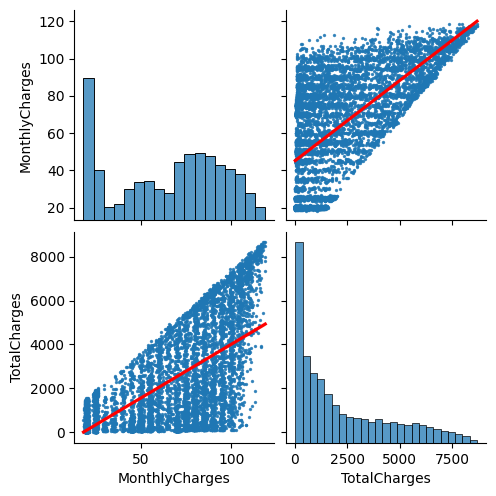

In [222]:
plot_kws = {'scatter_kws': {'s': 2}, 'line_kws': {'color': 'red'}}
sns.pairplot(cluster, kind='reg', vars=cluster.columns[:-1], plot_kws=plot_kws)
plt.show()

Диаграммы рассеяния показывают, что кластеры датасета не видны на диаграммах, что указывает на то, что они нечетко отделены друг от друга. Видим, что переменные имеют сильную линейную связь, что выделяется линиями регрессии

In [223]:
# промасштабируем, чтобы каждая переменная имела равную важность при подборе алгоритма k-средних
scaled_cluster = StandardScaler().fit_transform(cluster)

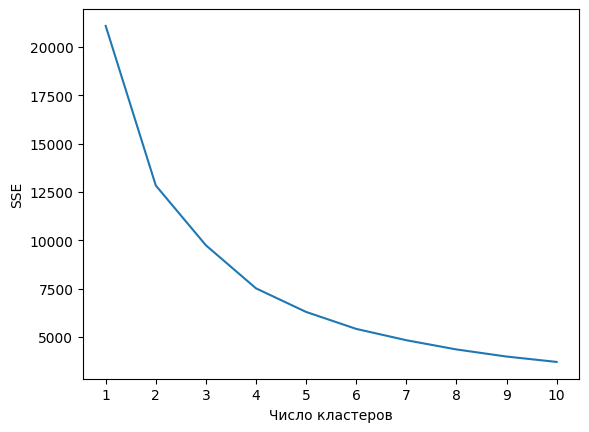

In [224]:
# найдем оптимальное число кластеров
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": SEED,
}

sse = [] # sum of squared errors
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_cluster)
    sse.append(kmeans.inertia_)

# визуализируем результыт
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Число кластеров")
plt.ylabel("SSE")
plt.show()

На графике видно, что в числе кластеров k = 3 имеется изгиб.

In [225]:
# проведем кластеризацию k-means, используя оптимальное количество кластеров
kmeans = KMeans(init="random", n_clusters=3, n_init=10, random_state=SEED)

kmeans.fit(scaled_cluster)

# просмотрим на значения кластеров для каждого наблюдения
kmeans.labels_

array([0, 2, 2, ..., 0, 2, 1], dtype=int32)

In [226]:
# добавим кластеры к датафрему
df['Cluster'] = kmeans.labels_
df['Cluster'] = df['Cluster'].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SeniorCitizen         7032 non-null   object 
 1   Partner               7032 non-null   object 
 2   Dependents            7032 non-null   object 
 3   Type                  7032 non-null   object 
 4   PaperlessBilling      7032 non-null   object 
 5   PaymentMethod         7032 non-null   object 
 6   MonthlyCharges        7032 non-null   float64
 7   TotalCharges          7032 non-null   float64
 8   InternetService       7032 non-null   object 
 9   OnlineSecurity        7032 non-null   object 
 10  OnlineBackup          7032 non-null   object 
 11  DeviceProtection      7032 non-null   object 
 12  TechSupport           7032 non-null   object 
 13  StreamingTV           7032 non-null   object 
 14  StreamingMovies       7032 non-null   object 
 15  MultipleLines        

In [227]:
# удалим столбцы, на основе которых был создан новый признак DailyCharges
df = df.drop(['TotalCharges', 'SubscriptionDuration'], axis = 1)

In [228]:
#df = df.drop(['MonthlyCharges','DailyCharges'], axis = 1)

In [229]:
#df = df.drop(['SeniorCitizen', 'Dependents'], axis = 1)

In [230]:
# выделим целевой признак и остальные признаки

X = df.drop('Termination', axis=1)
y = df['Termination']

Так как в исходном датасете классы сильно несбалансированы, чтобы получить такое же распределение классов в каждой выборке после разделения на выборки, применим стратификацию.

In [231]:
# разделим данные на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .25,
                                                    random_state = SEED,
                                                     stratify=y)

0    0.734168
1    0.265832
Name: Termination, dtype: Float64


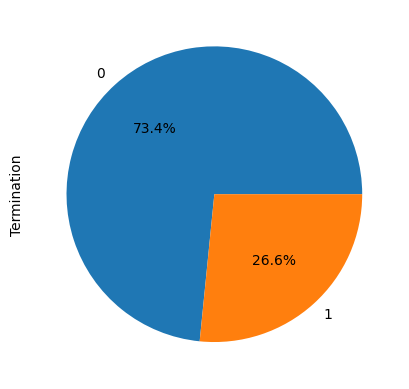

In [232]:
# проверим, как часто в тренировочной выборке встречается класс «1» или «0»
class_frequency = y_train.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='pie', y = "Termination",
                                       label = "Termination",
                                       autopct='%1.1f%%')
plt.show()

0    0.734357
1    0.265643
Name: Termination, dtype: Float64


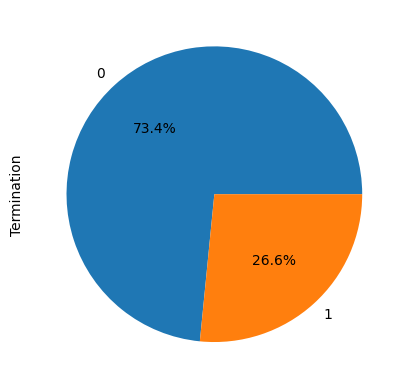

In [233]:
# проверим, как часто в тестовой выборке встречается класс «1» или «0»
class_frequency = y_test.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='pie', y = "Termination",
                                       label = "Termination",
                                       autopct='%1.1f%%')
plt.show()

При разделении на тренировочную и тестовую выборки распределение классов такое же как у всего исходного датасета.

In [234]:
# подготовим данные для обучения моделей

numeric = list(X.select_dtypes(include=['int64', 'float64']).columns)
categorical = list(X.select_dtypes(include='object').columns)

#numeric = ['MonthlyCharges', 'DailyCharges']
#categorical = ['SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod', 'TechSupport', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Cluster']

col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numeric),
                            ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
                                remainder="passthrough"
                                  ).set_output(transform='pandas')

col_transformer.fit(X_train)#
feature_names = col_transformer.get_feature_names_out()
features_train = col_transformer.transform(X_train)
features_test = col_transformer.transform(X_test)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [235]:
feature_names

array(['scaler__MonthlyCharges', 'scaler__DailyCharges',
       'ohe__SeniorCitizen_Yes', 'ohe__Partner_Yes',
       'ohe__Dependents_Yes', 'ohe__Type_One year', 'ohe__Type_Two year',
       'ohe__PaperlessBilling_Yes',
       'ohe__PaymentMethod_Credit card (automatic)',
       'ohe__PaymentMethod_Electronic check',
       'ohe__PaymentMethod_Mailed check',
       'ohe__InternetService_Fiber optic',
       'ohe__InternetService_No internet',
       'ohe__OnlineSecurity_No internet', 'ohe__OnlineSecurity_Yes',
       'ohe__OnlineBackup_No internet', 'ohe__OnlineBackup_Yes',
       'ohe__DeviceProtection_No internet', 'ohe__DeviceProtection_Yes',
       'ohe__TechSupport_No internet', 'ohe__TechSupport_Yes',
       'ohe__StreamingTV_No internet', 'ohe__StreamingTV_Yes',
       'ohe__StreamingMovies_No internet', 'ohe__StreamingMovies_Yes',
       'ohe__MultipleLines_No phone', 'ohe__MultipleLines_Yes',
       'ohe__Cluster_1', 'ohe__Cluster_2'], dtype=object)

Все таблицы объединены так, чтобы каждому клиенту соответствовало одно наблюдение.

Данные проверены на пропуски и выбросы. Пропуски заполнены. Сделан визуализация и корреляционный анализ.

Признак gender, не коррелирующий с целевой переменной Termination, удален.

Созданы дополнительные признаки Длительность контракта, Дневные расходы, Кластер.

Данные разделены на тренировочнцю и тестовую выборки и подготовлены для обучения модели.




# Обучение моделей

Проведем оценку на кросс-валидации с использованием стратификации при разбиении на фолды

In [236]:
kf = StratifiedKFold(n_splits=5)

Найдем лучшую модель для прогноза оттока клиентов. Оценивать её качество будем метрикой ROC-AUC. Лучшую модель по значению метрики оценим на кросс-валидации

## Случайный лес

In [237]:
param_grid_rf = {'max_depth':[None] + [i for i in range(2, 9)], 'n_estimators':[100, 1000, 50]}

model_rf = RandomForestClassifier(random_state=SEED)
clf_rf = GridSearchCV(estimator=model_rf,
                          param_grid=param_grid_rf,
                          scoring='roc_auc',
                          cv = kf,
                          n_jobs=-1)

clf_rf.fit(features_train, y_train)
print(clf_rf.best_params_)
clf_rf.best_score_

{'max_depth': 8, 'n_estimators': 1000}


0.8396763218554172

Создадим функцию для сравнения моделей и их полученных метрик

In [238]:
result = pd.DataFrame(columns = ['ROC_AUC'])

def results_table(name, roc_auc):
    result.loc[name, ['ROC_AUC']] = roc_auc
    return result

In [239]:
results_table('RandomForestClassifier', round(clf_rf.best_score_, 4))

,ROC_AUC
RandomForestClassifier,0.8397


## Бустинг LGBM

In [240]:
param_grid_lgb = {'n_estimators': [100, 500, 100], 'max_depth': [i for i in range(3, 12)], 'learning_rate': [0.01, 0.1]}
model_lgb = lgb(random_state=SEED)

clf_lgb=GridSearchCV(estimator=model_lgb,
                          param_grid=param_grid_lgb,
                          scoring='roc_auc',
                          cv = kf,
                          n_jobs=-1)

clf_lgb.fit(features_train, y_train)
print(clf_lgb.best_params_)
clf_lgb.best_score_

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1402, number of negative: 3872
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 5274, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265832 -> initscore=-1.015871
[LightGBM] [Info] Start training from score -1.015871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

0.8427704854340174

In [241]:
results_table('LGBMClassifier', round(clf_lgb.best_score_, 4))

,ROC_AUC
RandomForestClassifier,0.8397
LGBMClassifier,0.8428


## Бустинг CatBoost

In [242]:
param_grid_cbc = {'max_depth': [i for i in range(5, 12)],
                  'learning_rate':[0.01, 0.1],
                  'iterations': [400, 500]}

model_cbc = CatBoostClassifier(random_state=SEED)
clf_cbc=GridSearchCV(estimator=model_cbc,
                          param_grid=param_grid_cbc,
                          scoring='roc_auc',
                          cv = kf,
                          n_jobs=-1)

clf_cbc.fit(features_train, y_train)
print(clf_cbc.best_params_)
clf_cbc.best_score_

0:	learn: 0.6868096	total: 3.14ms	remaining: 1.57s
1:	learn: 0.6806476	total: 6.92ms	remaining: 1.72s
2:	learn: 0.6750373	total: 9.76ms	remaining: 1.62s
3:	learn: 0.6694350	total: 12.6ms	remaining: 1.57s
4:	learn: 0.6639056	total: 14.8ms	remaining: 1.46s
5:	learn: 0.6577599	total: 17.5ms	remaining: 1.44s
6:	learn: 0.6521683	total: 20.3ms	remaining: 1.43s
7:	learn: 0.6459479	total: 23.1ms	remaining: 1.42s
8:	learn: 0.6400540	total: 29.6ms	remaining: 1.61s
9:	learn: 0.6345162	total: 38.9ms	remaining: 1.91s
10:	learn: 0.6288825	total: 42.3ms	remaining: 1.88s
11:	learn: 0.6239044	total: 44.9ms	remaining: 1.82s
12:	learn: 0.6197073	total: 47.5ms	remaining: 1.78s
13:	learn: 0.6147834	total: 50.1ms	remaining: 1.74s
14:	learn: 0.6107802	total: 52.7ms	remaining: 1.7s
15:	learn: 0.6064374	total: 55.4ms	remaining: 1.68s
16:	learn: 0.6021044	total: 58.1ms	remaining: 1.65s
17:	learn: 0.5978502	total: 60.9ms	remaining: 1.63s
18:	learn: 0.5933537	total: 63.5ms	remaining: 1.61s
19:	learn: 0.5893942	to

0.8441567739969222

In [243]:
results_table('CatBoostClassifier', round(clf_cbc.best_score_, 4))

,ROC_AUC
RandomForestClassifier,0.8397
LGBMClassifier,0.8428
CatBoostClassifier,0.8442


## Нейронные сети

In [244]:
# разделим данные на тренировочную и валидационную выборки для обучения и проверки качества нейронной сети

X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train, y_train,
                                                    test_size = .2,
                                                    random_state = SEED,
                                                     stratify=y_train)

In [245]:
# подготовим данные

numeric = list(X_train_nn.select_dtypes(include=['int64', 'float64']).columns)
categorical = list(X_train_nn.select_dtypes(include='object').columns)

#numeric = ['MonthlyCharges', 'DailyCharges']
#categorical = ['SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod', 'TechSupport', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Cluster']

col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numeric),
                            ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
                                remainder="passthrough"
                                  ).set_output(transform='pandas')

col_transformer.fit(X_train_nn)
features_train_nn = col_transformer.transform(X_train_nn)
features_val_nn = col_transformer.transform(X_val_nn)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [246]:
features_train_nn.shape, features_val_nn.shape, y_train_nn.shape, y_val_nn.shape

((4219, 29), (1055, 29), (4219,), (1055,))

In [247]:
NN = models.Sequential(
    [
        keras.layers.Dense(29, activation="relu", input_shape=(features_train_nn.shape[1],)),
        keras.layers.Dense(24, activation="relu"),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
    ]
)
NN.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 29)                870       
                                                                 
 dense_49 (Dense)            (None, 24)                720       
                                                                 
 dense_50 (Dense)            (None, 16)                400       
                                                                 
 dense_51 (Dense)            (None, 8)                 136       
                                                                 
 dense_52 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2135 (8.34 KB)
Trainable params: 2135 (8.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [248]:
optimizer = Adam(learning_rate=0.0001)
scikeras_classifier = KerasClassifier(model=NN,
                                      optimizer=optimizer,
                                      loss=keras.losses.binary_crossentropy,
                                      batch_size=16,
                                      epochs=50,
                                      verbose=0,
                                      validation_split=0.1
                                      )

In [249]:
scikeras_classifier.fit(features_train_nn, y_train_nn)
y_probs_nn = scikeras_classifier.predict_proba(features_val_nn)[:,1]
roc_auc_nn = roc_auc_score(y_val_nn, y_probs_nn)

In [250]:
results_table('Neural Network', round(roc_auc_nn, 4))

,ROC_AUC
RandomForestClassifier,0.8397
LGBMClassifier,0.8428
CatBoostClassifier,0.8442
Neural Network,0.834


Лучшую метрику показала модель бустинга CatBoost, равную 0.8442

# Тестирование модели

Протестируем лучшую модель

In [251]:
booster = CatBoostClassifier(random_state=SEED,
                           iterations = 500,
                           learning_rate = 0.01,
                           max_depth = 5).fit(features_train, y_train)
predictions = booster.predict(features_test)

0:	learn: 0.6870924	total: 2.81ms	remaining: 1.4s
1:	learn: 0.6813588	total: 7.35ms	remaining: 1.83s
2:	learn: 0.6756443	total: 11.3ms	remaining: 1.87s
3:	learn: 0.6701791	total: 14.3ms	remaining: 1.77s
4:	learn: 0.6652825	total: 16.9ms	remaining: 1.68s
5:	learn: 0.6594417	total: 19.9ms	remaining: 1.64s
6:	learn: 0.6532983	total: 22.2ms	remaining: 1.56s
7:	learn: 0.6475688	total: 25.4ms	remaining: 1.56s
8:	learn: 0.6422583	total: 27.7ms	remaining: 1.51s
9:	learn: 0.6367413	total: 30.5ms	remaining: 1.49s
10:	learn: 0.6316625	total: 33.5ms	remaining: 1.49s
11:	learn: 0.6272588	total: 38ms	remaining: 1.54s
12:	learn: 0.6230403	total: 42.2ms	remaining: 1.58s
13:	learn: 0.6181673	total: 45.7ms	remaining: 1.59s
14:	learn: 0.6142869	total: 52.1ms	remaining: 1.68s
15:	learn: 0.6096263	total: 57.5ms	remaining: 1.74s
16:	learn: 0.6052825	total: 63.9ms	remaining: 1.81s
17:	learn: 0.6013056	total: 69.1ms	remaining: 1.85s
18:	learn: 0.5968824	total: 71.3ms	remaining: 1.81s
19:	learn: 0.5933613	tota

In [252]:
# вычислим AUC-ROC на тестовой выборке
y_pred_proba = booster.predict_proba(features_test)[:, 1]

auc_roc = roc_auc_score(y_test, y_pred_proba)
print('AUC-ROC на тестовой выборке:', round(auc_roc, 4))
# дополнительно вычислим accuracy
accuracy = accuracy_score(y_test, predictions)
print('Accuracy на тестовой выборке:', round(accuracy, 4))

AUC-ROC на тестовой выборке: 0.857
Accuracy на тестовой выборке: 0.7969


На тестовой выборке модель CatBoost подтвердила результат.

Проведем графический анализ «Матрица ошибок» и выведим полноту и точность на график

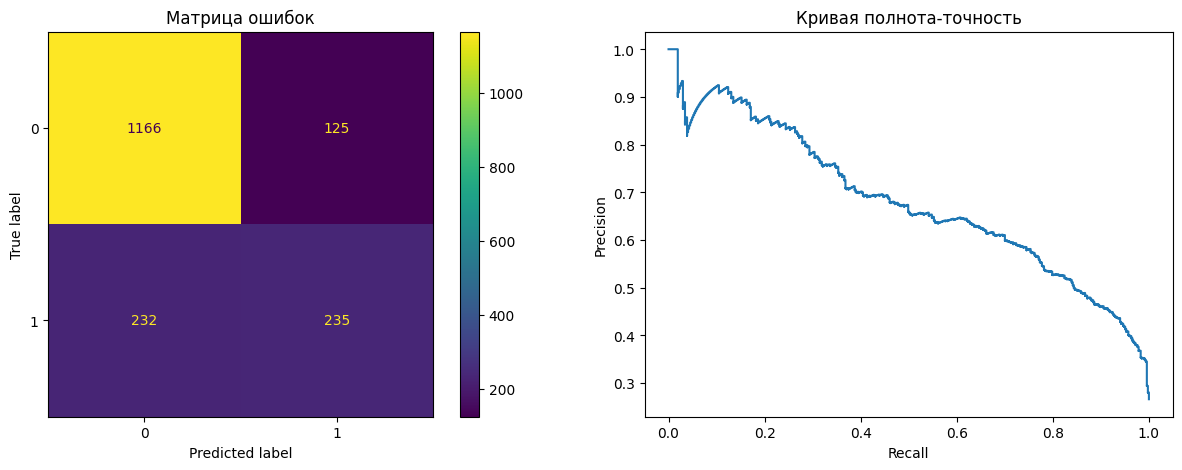

In [253]:
matrix = confusion_matrix(y_test, predictions, labels=clf_cbc.classes_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
cmd = ConfusionMatrixDisplay(matrix, display_labels=clf_cbc.classes_)
cmd.plot(ax=ax1)
ax1.set_title('Матрица ошибок')
prec, recall, _ = precision_recall_curve(y_test, y_pred_proba)
PrecisionRecallDisplay(prec, recall).plot(ax=ax2)
ax2.set_title('Кривая полнота-точность')
plt.show()

На кривой полнота-точность в самой нижней точке, т.е. в (0, 0) - порог устанавливается равным 1,0. Это означает, что модель не делает различий между произошел отток абонента или нет.
В самой высокой точке, то есть в (1, 1), порог устанавливается на 0,0. Это означает, что и точность, и полнота высоки, и модель прекрасно различает.
Остальная часть кривой — это значения Precision и Recall для пороговых значений от 0 до 1. Цель — сделать кривую как можно ближе к (1, 1), что означает хорошую точность и полноту.

Как мы видим, точность предсказаний модели не очень высокая, т.к. есть скрытые (неучтенные, несобранные) от модели факторы, но объяснение причин, почему модель сделала такое предсказание, может помочь заказчику обратить внимание на новые факторы.

Проанализируем важность основных входных признаков, влияющих на отток клиентов.

In [254]:
importances = booster.get_feature_importance(prettified=True)

Создадим функцию, чтобы удалить приставки в названиях признаков.

In [255]:
def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

In [256]:
importance = importances['Feature Id']
importance = importances['Feature Id'].map(lambda x: remove_prefix(x, "ohe__"))
importances['Feature Id'] = importance

In [257]:
importance = importances['Feature Id'].map(lambda x: remove_prefix(x, "scaler__"))

importances['Feature Id'] = importance

In [258]:
importances

,Feature Id,Importances
0,DailyCharges,19.263180
1,Type_Two year,18.115819
2,InternetService_Fiber optic,13.493286
3,MonthlyCharges,6.484978
4,Type_One year,6.205119
5,PaymentMethod_Electronic check,3.803424
6,Cluster_1,3.490160
7,MultipleLines_Yes,2.635761
8,PaperlessBilling_Yes,2.487942
9,TechSupport_Yes,2.434794


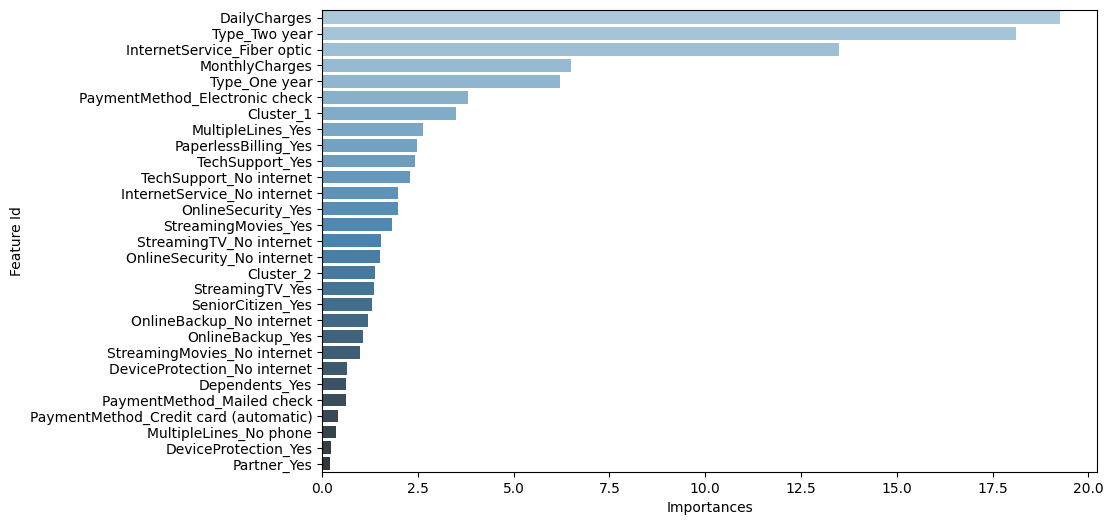

In [259]:
importances.sort_values('Importances', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10,6))
ax=sns.barplot(x="Importances", y="Feature Id", data=importances, palette="Blues_d", orient='h');


Для анализа важности признаков также используем библиотеку SHAP, в которой для оценки важности признака происходит оценка предсказаний модели с и без данного признака.

In [260]:
# сгенерируем оценщик значений Шепли, который соответствует построенной модели бустинга
explainer = shap.TreeExplainer(booster, feature_perturbation='interventional')
# вычислим значения Шепли для тестовой выборки
shap_values = explainer.shap_values(features_test)

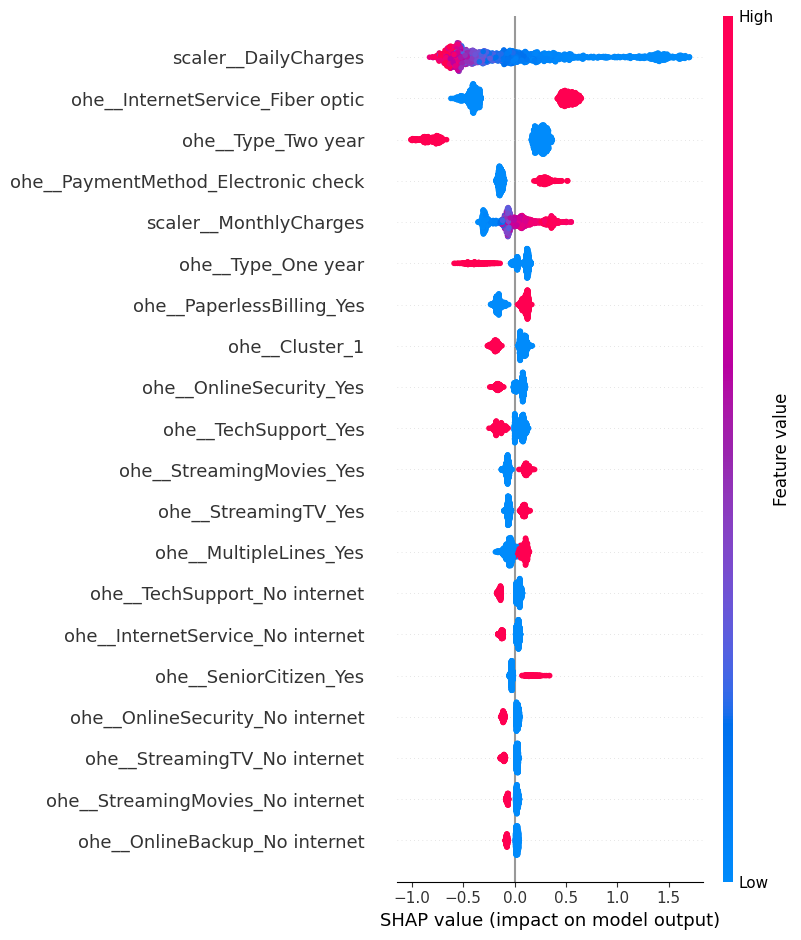

In [261]:
shap.summary_plot(shap_values, features_test)

С помощью различных инструментов получили схожие результаты: основной фактор - это дневные расходы.

Боковая цветовая полоса указывает на значение признака, а по оси x - на оказываемое влияние.

Построим график зависимости одного из важных входных признаков и целевого признаков. Возьмем MonthlyCharges, так как DailyCharges признак синтетический, имеет скрытые факторы и зависит от длительности контракта.

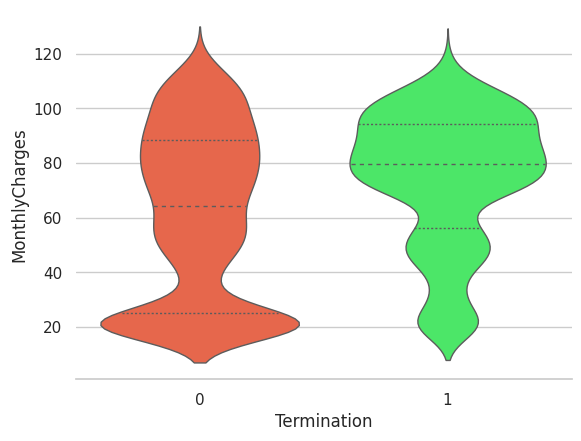

In [262]:
sns.set_theme(style="whitegrid")

custom_palette = ["#FF5733", "#33FF57"] # пользовательский список цветов

sns.violinplot(data=df, x="Termination", y="MonthlyCharges",
               split=True, inner="quart", linewidth=1,
               palette=custom_palette)
sns.despine(left=True)

Чаще всего расторгают договор при высоких ежемесячных расходах. Чем меньше ежемесячные расходы, тем реже.

# **Выводы**

Лучшей моделью с метрикой 0.857 является модель CatBoost.
Основной фактор, влияющий на отток абонентов является дневные расходы абонента.

По матрице ошибок видно, что модель примерно в 2 раза чаще ошибается в предсказании положительного класса (ложноотрицательные), нежели с отрицательным (ложно положительные). С точки зрения бизнеса - это плохой показатель, так как бизнес рискует пропустить клиентов, склонных к оттоку, и не смогут удержать их, предложив купоны или промо-тариф.

В целом пока невозможно создать адекватную системы оценки оттока абонентов в силу наличия скрытых факторов.

В данных заказчика не было данных по абоненту таких как его возраст и доход. Это те факторы, которые вероятно будут способствовать уточнению предсказаний. Следует рекомендовать собирать эти данные и иные дополнительные.